[View in Colaboratory](https://colab.research.google.com/github/iampatgrady/Clustering-Analysis-using-TensorFlow-and-BigQuery/blob/master/ML_Demo_Clustering_Analysis_using_TensorFlow.ipynb)

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.preprocessing import StandardScaler   
import urllib2
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#@title Enter your BigQuery project ID { run: "auto", display-mode: "form" }
project = "<your project id>" #@param {type:"string"}
target = "bigquery-public-data.google_analytics_sample.ga_sessions_*" #@param {type:"string"}
start = "2017-07-01" #@param {type:"date"}
end = "2017-08-01" #@param {type:"date"}


[Clustering SQL Code](https://storage.googleapis.com/pats-test/sql/bigquery_google_merchandise_clustering.sql)

In [21]:
sql_query = urllib2 \
  .urlopen("https://storage.googleapis.com/pats-test/sql/bigquery_google_merchandise_clustering.sql") \
  .read().format(target,start.replace("-",""),end.replace("-",""))

ga_data = pd.io.gbq.read_gbq(sql_query,project_id=project,dialect='standard')

print ga_data.shape
ga_data.sample(5)

(573463, 20)


,fullVisitorId,sessions,timeOnSite,pageviews,gaHits,transactions,revenue,sessionQuality,basketViews,homeViews,signinView,storeView,ordercompletedViews,apparelViews,shopbybrandViews,nestViews,accessoryViews,bagViews,officeViews,drinkwareViews
393299,8722340407073237841,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473363,0329128968086399249,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370637,5188241849816652526,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
385341,9050910859081541475,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164862,60661209431402778,1,65.0,4.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [0]:
def input_fn():
    return tf.constant(np_norm_data, tf.float32, np_norm_data.shape), None

!rm -rf models
!mkdir models
data = ga_data.drop('fullVisitorId',axis=1).copy()  # do not shuffle data from this point on
std_scaler = StandardScaler()
np_norm_data = std_scaler.fit_transform(data)
columns = data.columns
k=10

In [0]:
kmeans = tf.contrib.learn.KMeansClustering( 
    num_clusters=k, 
    relative_tolerance=0.001,
    model_dir='models',
    initial_clusters='kmeans_plus_plus',
)

kmeans.fit(input_fn=input_fn)
assignments = list(kmeans.predict_cluster_idx(input_fn=input_fn))

In [24]:
clusters = std_scaler.inverse_transform(kmeans.clusters())

cluster_metrics_pd = pd.DataFrame(clusters, columns=columns)
cluster_metrics_pd['total_users'] = pd.get_dummies(assignments).agg("sum")

assign_output = pd.DataFrame()
assign_output['fullVisitorId'] = ga_data.fullVisitorId
assign_output["class"] = assignments
assign_output = assign_output.merge(ga_data, on='fullVisitorId')

print assign_output.shape
assign_output.sample(10)

(573463, 21)


,fullVisitorId,class,sessions,timeOnSite,pageviews,gaHits,transactions,revenue,sessionQuality,basketViews,...,signinView,storeView,ordercompletedViews,apparelViews,shopbybrandViews,nestViews,accessoryViews,bagViews,officeViews,drinkwareViews
568572,6384329866495516492,8,25,318.000000,10.800000,13.200000,0.4,17.566,0.0,1.400000,...,0.800000,0.200000,0.8,3.200000,0.0,0.0,0.0,0.000000,0.0,0.000000
443342,6460693324693641749,0,1,0.000000,1.000000,1.000000,0.0,0.000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
25342,65808488211502786,8,1,84.000000,5.000000,5.000000,0.0,0.000,0.0,0.000000,...,4.000000,0.000000,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.000000
300357,9559056306903724020,6,1,1300.000000,5.000000,5.000000,0.0,0.000,0.0,0.000000,...,0.000000,0.000000,0.0,3.000000,0.0,0.0,0.0,2.000000,0.0,0.000000
544962,1430408383608658111,6,9,321.333333,7.666667,9.333333,0.0,0.000,0.0,0.666667,...,0.333333,0.666667,0.0,0.666667,0.0,0.0,1.0,1.333333,0.0,0.333333
26137,1053935819146618532,0,1,42.000000,6.000000,6.000000,0.0,0.000,0.0,0.000000,...,1.000000,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
23013,8743848518710163048,0,1,49.000000,5.000000,5.000000,0.0,0.000,0.0,0.000000,...,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
205285,614048480179691465,6,4,438.000000,22.000000,28.500000,0.0,0.000,0.0,0.000000,...,0.000000,0.000000,0.0,13.000000,0.5,0.0,0.0,0.500000,0.0,0.000000
401305,8678801429021057166,0,1,0.000000,1.000000,1.000000,0.0,0.000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
454964,7420037597401029840,0,1,0.000000,1.000000,1.000000,0.0,0.000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


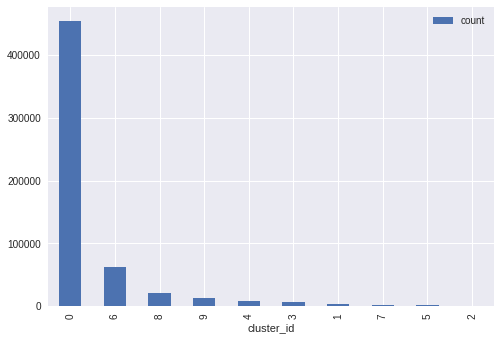

In [25]:
cp = assign_output.groupby("class")['fullVisitorId'].agg("count") \
  .reset_index(drop=True).sort_values(ascending=False)
cp = pd.DataFrame({'cluster_id':cp.index, 'count':cp.values})
cp.plot(kind="bar",x="cluster_id")
plt.show()

# Using Labeled Data to Train ML Model

In [0]:
# create simple weight to determine the "high_value_target"
cluster_metrics_pd["weighted_score"] = (
    cluster_metrics_pd.revenue * 
    cluster_metrics_pd.sessions * 
    cluster_metrics_pd.total_users
).sort_values(ascending=False)

In [32]:
# compress the labels to binary group
high_value_target = cluster_metrics_pd.weighted_score.idxmax()
print "High Value Target is Cluster Id: {}".format(high_value_target)
assign_output['class'] = assign_output['class'].astype(str)
assign_output['class'] = assign_output['class'].str.replace(r'[^' + str(high_value_target) + ']', "0")

High Value Target is Cluster Id: 8


In [33]:
#Seperating dependent and independent variables. 
X = assign_output.iloc[:, 2:assign_output.shape[1]].values  #Note: Exclude Last column with all NaN values.
y = assign_output.iloc[:, 1].values
print X.shape, y.shape
pd.Series(y).value_counts()

(573463, 19) (573463,)


0    551829
8     21634
dtype: int64

In [34]:
#Encoding Categorical Data
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

y = labelencoder.fit_transform(y)
pd.Series(y).value_counts()

0    551829
1     21634
dtype: int64

In [0]:
#Splitting into Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [0]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.fit_transform(X_test)

# ANN

In [0]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

In [0]:
# Initialising the ANN
classifier = Sequential()

feat_len = X.shape[1]
dense_units = int(feat_len/2)+1

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = dense_units, kernel_initializer = 'uniform', activation = 'relu', input_dim = feat_len))

# Adding the second hidden layer
classifier.add(Dense(units = dense_units, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 1000, epochs = 10)

Epoch 1/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0245 - acc: 0.9930
Epoch 2/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0197 - acc: 0.9937
Epoch 3/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0168 - acc: 0.9942
Epoch 4/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0158 - acc: 0.9946
Epoch 5/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0151 - acc: 0.9949
Epoch 6/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0145 - acc: 0.9952
Epoch 7/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0138 - acc: 0.9954
Epoch 8/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0131 - acc: 0.9958


Epoch 9/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0109 - acc: 0.9964
Epoch 10/10
458770/458770 [==============================] - 1s 3us/step - loss: 0.0092 - acc: 0.9967


In [0]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)   

In [42]:
pd.Series(y_test).value_counts()

0    110316
1      4377
dtype: int64

![alt text](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png)

[[110191    125]
 [   261   4116]]


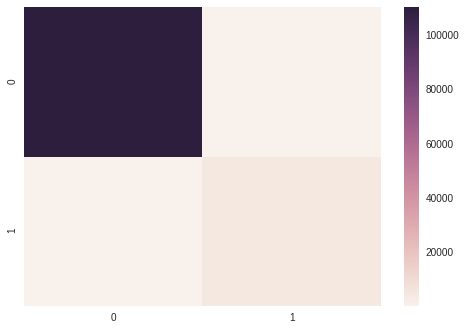

In [43]:
print cm
sns.heatmap(cm)
plt.show()